# Example: Assessing the synthesizability of non-natural amino acids

This notebook demonstrates how to assess the synthesizability of non-natural amino acids (NNAAs) using the NNAASynth tool. The workflow includes protecting the amino acid, running AizynthFinder to propose synthetic routes, and scoring the routes for feasibility using Chemformer and an expert-augmented model.

#### Import the relevant packages and assign the path variables

In [1]:
import os
from rdkit import Chem
from nnaasynth.workflow_components.running import RunAiZynthFinder
from nnaasynth.workflow_components.scoring import FeasibilityScorer
from nnaasynth.workflow_components.protection import Protection
from nnaasynth.run_synthesizability_analysis import RunSynthesizabilityAnalysis

In [2]:
# The folder containing reactive substructures, protection groups and related heuristics. These files are located in the rxnutils repo in examples/nnaa
path_to_protection_files = "/path/to/reaction_utils/examples/nnaa"

# Path to the AizynthFinder configuration file, an example file is located at nnaasynth/aizynthfinder_setup/aizynth_config.yml
path_to_aizynth_config = "/path/to/aizynth_config.yml"

# Path to Expert-augmented model files, as described in README.md:
path_to_expert_augmented_model_files = "/path/to/expert_augmented_models"

# Path to save the final image with the results
path_to_save = "/path/to/save/folder"

#### Initialize the workflow components for protection strategy, aizynthfinder, and route scorers

Protection

In [3]:
smartslib_path=os.path.join(path_to_protection_files, "reactive_functions_ontology.txt")
reaction_rules_path=os.path.join(path_to_protection_files, "protection_reactions.csv")
protection_groups_path=os.path.join(path_to_protection_files, "protection_groups.csv")
protection = Protection(smartslib_path, reaction_rules_path, protection_groups_path)

AiZynthFinder

In [4]:
aizynthfinder = RunAiZynthFinder(config_path=path_to_aizynth_config)

Chemformer and Expert-Augmented model

- Insert port number of the Chemformer API.
- Make sure the Chemformer API is running on the specified port

In [5]:
port = '8003'
chemformer_url = f"http://localhost:{port}/chemformer-api/predict"
feasibility = FeasibilityScorer(chemformer_url, path_to_expert_augmented_model_files)

#### Initialize the analyzer
The analyzer contains the functionalities to run the NNAASynth tool end-to-end as demonstrated at the end of this notebook.

In [6]:
analyzer = RunSynthesizabilityAnalysis(protection, aizynthfinder, feasibility)

#### Set the query non-natural amino acid

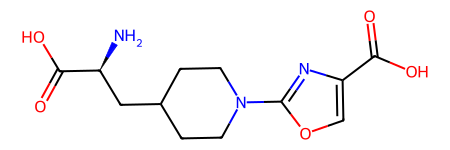

In [12]:
query_amino_acid = "N[C@@H](CC1CCN(c2nc(C(=O)O)co2)CC1)C(=O)O"
Chem.MolFromSmiles(query_amino_acid)

#### Protect the amino acid

The number of protected versions for the input NNAA:  4
('tBu', 'allyl', 'FMOC')


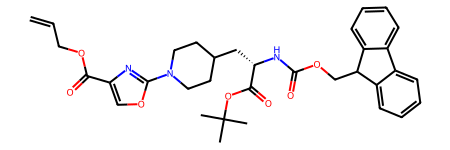

('tBu', 'Bn', 'FMOC')


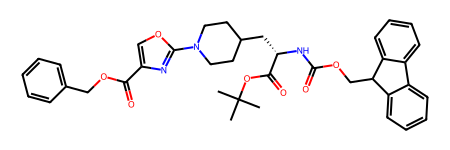

('tBu', 'TMSE', 'FMOC')


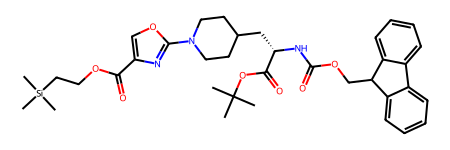

('tBu', 'PMB', 'FMOC')


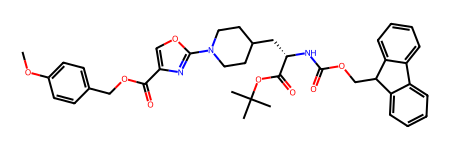

In [13]:
protected_amino_acids = protection.protect_amino_acid(query_amino_acid)

print("The number of protected versions for the input NNAA: ", len(protected_amino_acids))

for protected_smi in protected_amino_acids:
    print(protected_smi.protection_groups)
    display(Chem.MolFromSmiles(protected_smi.smiles))

#### Run Aizynthfinder
The protected amino acids are passed to AizynthFinder to propose synthetic routes. The results will include the proposed routes and their associated protection groups.

In [15]:
aizynthfinder_results = []
for nnaa in protected_amino_acids:
    aizynthfinder_result = aizynthfinder.run_single_smiles(nnaa)
    aizynthfinder_results.append(aizynthfinder_result)

Target amino acid: C=CCOC(=O)c1coc(N2CCC(C[C@H](NC(=O)OCC3c4ccccc4c4ccccc43)C(=O)OC(C)(C)C)CC2)n1 protected by ('tBu', 'allyl', 'FMOC')
Example proposed route:


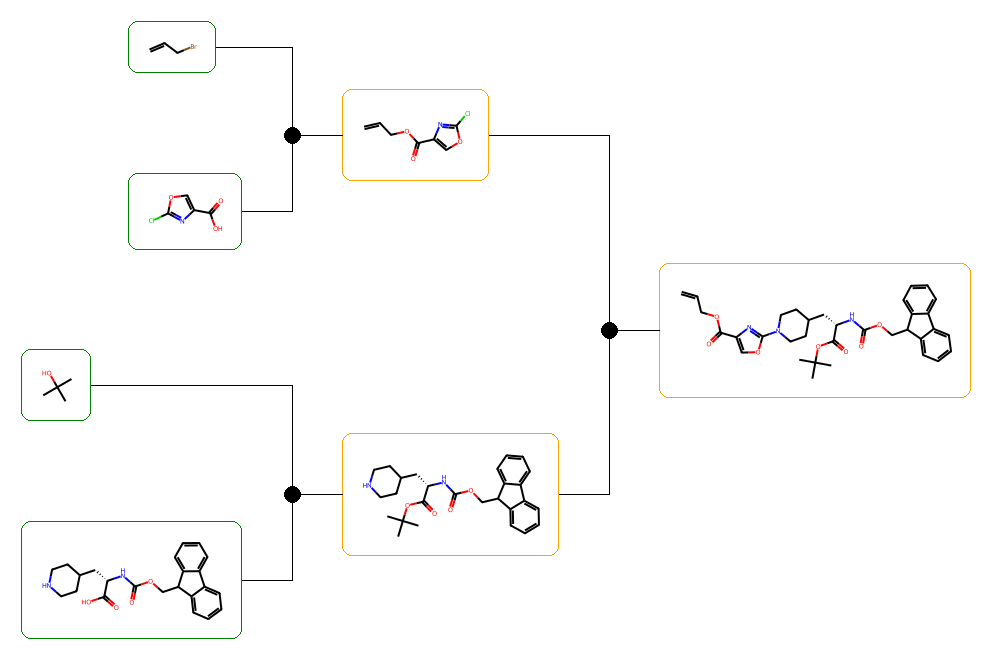

In [16]:
# Visualizing the first route for the first protected version
target_route = aizynthfinder_results[0]
print(f"Target amino acid: {target_route.smiles} protected by {target_route.protection_groups}")
print("Example proposed route:")
first_route = target_route.routes[0]
first_route.image()

#### Score the synthesizability of protected molecules with
#####    1) Chemformer model
#####    2) Expert-Augmented model
Passing the Chemformer score to the Expert-Augmented model scorer is optional. When Chemformer score is passed, the latter scorer deems the route infeasible if the passed score is 0.

**Note: The expert-augmented scorers are recommended to be used after annotating the routes with reaction classes with NextMove software[1]. The scores calculated without annotating the routes with the reaction classes will result in inconsistent scores from the expert-augmented model**

[1] NextMove Software | NameRxn, https://www.nextmovesoftware.com/namerxn.html
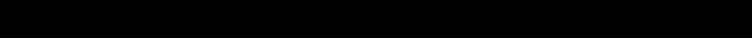
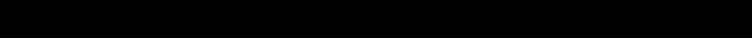
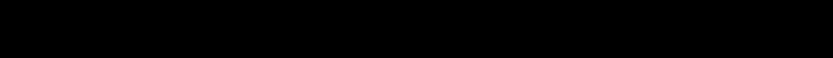
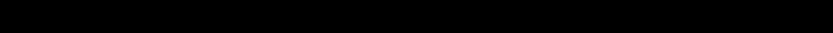
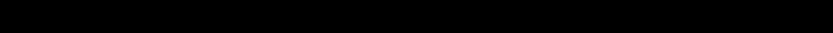

In [17]:
for amino_acid_data in aizynthfinder_results:
    chemformer_scores = [feasibility.score_with_chemformer(route) for route in amino_acid_data.routes]
    expert_augmented_scores = [feasibility.score_with_expert_augmented_feasibility(route, sc) for route, sc in zip(amino_acid_data.routes, chemformer_scores)]

    amino_acid_data.chemformer_scores = chemformer_scores
    amino_acid_data.expert_augmented_scores = expert_augmented_scores

    print(f"Protected Amino Acid: {amino_acid_data.smiles}")
    print(f"Scores from the Chemformer model:\n{chemformer_scores}")
    print(f"Scores from the Expert-Augmented model:\n{expert_augmented_scores}\n")

Protected Amino Acid: C=CCOC(=O)c1coc(N2CCC(C[C@H](NC(=O)OCC3c4ccccc4c4ccccc43)C(=O)OC(C)(C)C)CC2)n1
Scores from the Chemformer model:
[0.6070166962660546, 0.765167965312747, 0.3514973554359033, 0.0077100232665543, 0.0, 0.0, 0.0005989007357830076, 0.0, 0.0, 0.0]
Scores from the Expert-Augmented model:
[10.077094078063965, 9.212074279785156, 0.2545182704925537, 0.8020371794700623, 20.0, 20.0, -0.1865471601486206, 20.0, 20.0, 20.0]

Protected Amino Acid: CC(C)(C)OC(=O)[C@H](CC1CCN(c2nc(C(=O)OCc3ccccc3)co2)CC1)NC(=O)OCC1c2ccccc2c2ccccc21
Scores from the Chemformer model:
[0.026083492698687365, 0.4765180125632458, 0.01052350811931447, 0.010344720303351086, 0.7851515184930964, 0.017222139460608524, 0.7434656006165542, 0.01630776729892545, 0.004461141141469051, 9.785422696410904e-05, 0.18956845444513323, 0.1262717554611924, 0.0347447346814951, 0.0013377848079212894, 0.0012667580235032664, 7.601140295193114e-06, 0.009808562781175303, 0.0, 0.0, 0.0]
Scores from the Expert-Augmented model:
[10.

#### Select the best route

In [18]:
outcomes = []
for protected_form in aizynthfinder_results:
    outcome = analyzer.select_best_route(protected_form)
    outcomes.append(outcome)

Protected Amino Acid: C=CCOC(=O)c1coc(N2CCC(C[C@H](NC(=O)OCC3c4ccccc4c4ccccc43)C(=O)OC(C)(C)C)CC2)n1
Best route has chemformer score: 0.0005989007357830076 and expert augmented score: -0.1865471601486206

Protected Amino Acid: CC(C)(C)OC(=O)[C@H](CC1CCN(c2nc(C(=O)OCc3ccccc3)co2)CC1)NC(=O)OCC1c2ccccc2c2ccccc21
Best route has chemformer score: 0.009808562781175303 and expert augmented score: 0.16569054126739502

Protected Amino Acid: CC(C)(C)OC(=O)[C@H](CC1CCN(c2nc(C(=O)OCC[Si](C)(C)C)co2)CC1)NC(=O)OCC1c2ccccc2c2ccccc21
Best route has chemformer score: 0.0012201903666917864 and expert augmented score: -0.2769322395324707

Protected Amino Acid: COc1ccc(COC(=O)c2coc(N3CCC(C[C@H](NC(=O)OCC4c5ccccc5c5ccccc54)C(=O)OC(C)(C)C)CC3)n2)cc1
Best route has chemformer score: 0.00030860633587055533 and expert augmented score: 0.7586309909820557



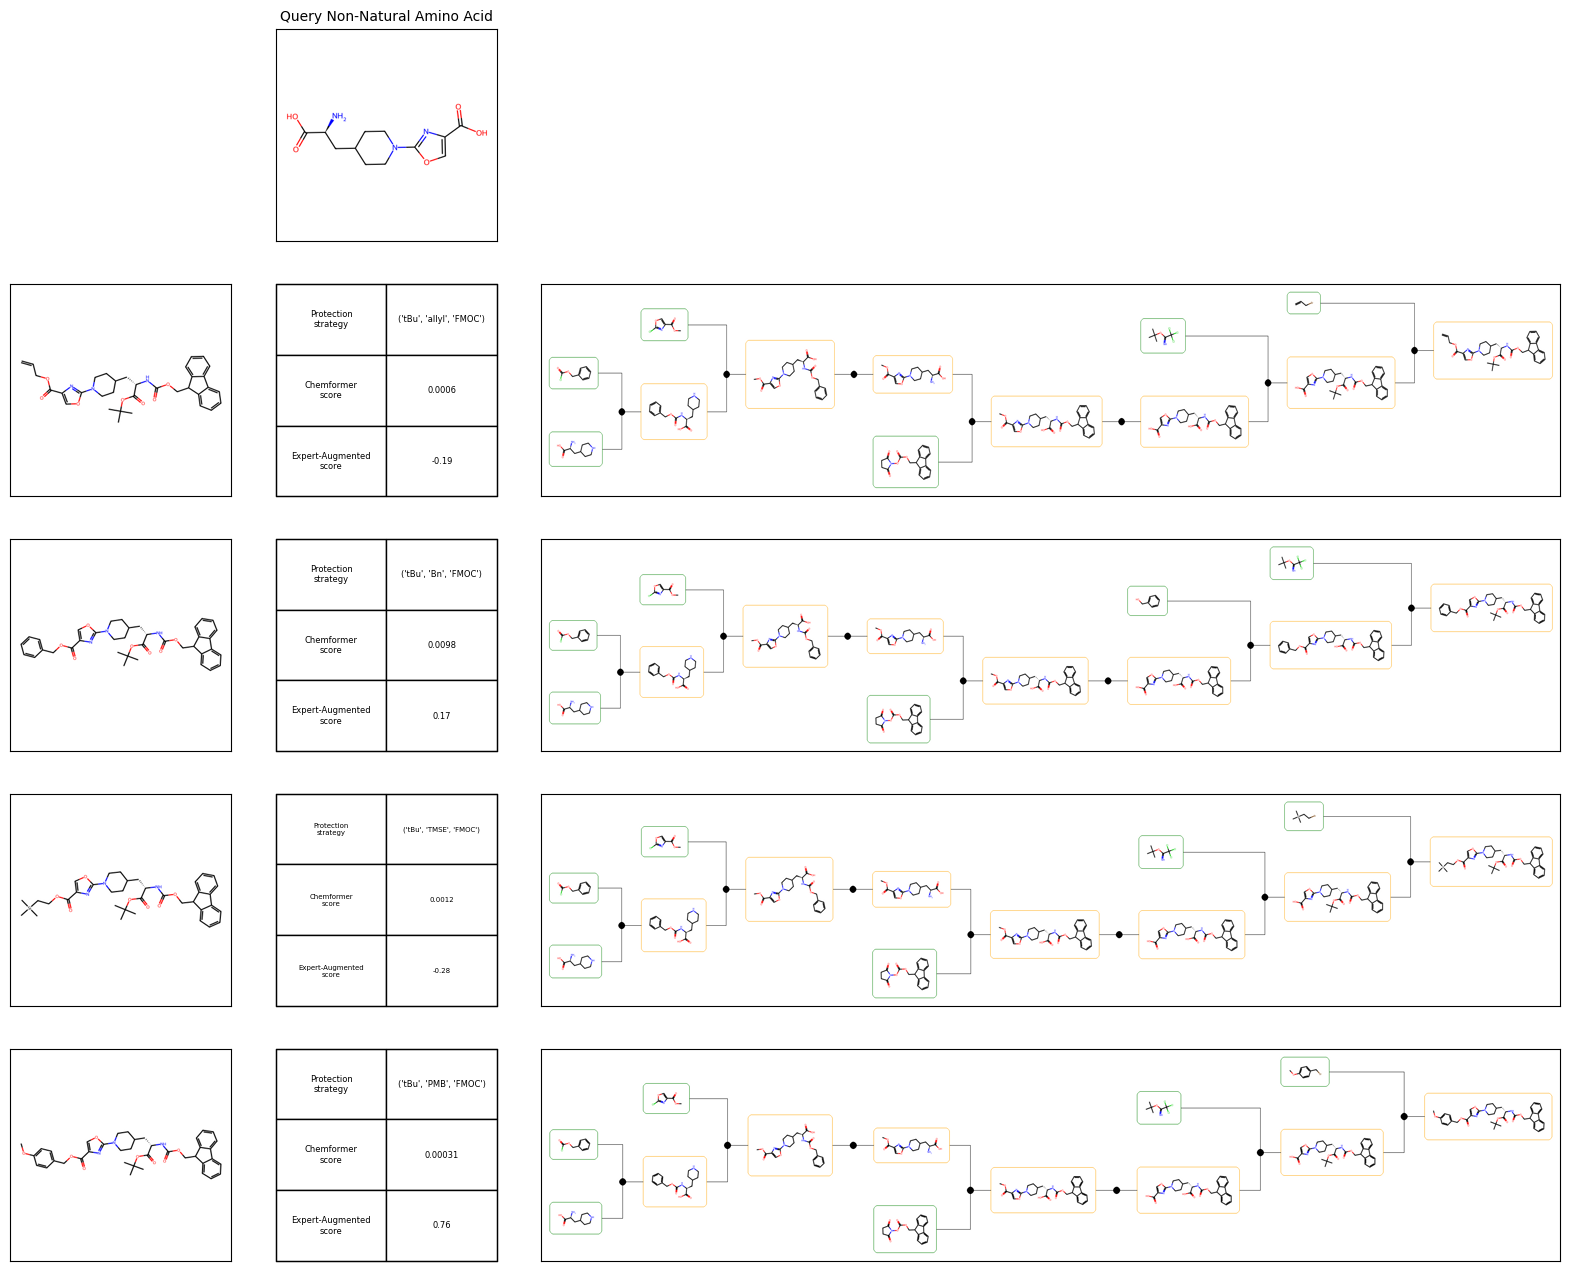

In [56]:
from nnaasynth.utils.plotting import plot_results
save_to = os.path.join(path_to_save, "nnaa_synthesizability_results.png")
plot_results(query_amino_acid, outcomes, save_to)

  #### The same results from this notebook can be generated simply by running this cell after initializing the NNAASynth components:

The number of protected versions for the input NNAA:  4
Running AiZynthFinder on 4 SMILES
[0.0%] 0/4 - Processed C=CCOC(=O)c1coc(N2CCC(C[C@H](NC(=O)OCC3c4ccccc4c4ccccc43)C(=O)OC(C)(C)C)CC2)n1: 10 routes found
[25.0%] 1/4 - Processed CC(C)(C)OC(=O)[C@H](CC1CCN(c2nc(C(=O)OCc3ccccc3)co2)CC1)NC(=O)OCC1c2ccccc2c2ccccc21: 20 routes found
[50.0%] 2/4 - Processed CC(C)(C)OC(=O)[C@H](CC1CCN(c2nc(C(=O)OCC[Si](C)(C)C)co2)CC1)NC(=O)OCC1c2ccccc2c2ccccc21: 3 routes found
[75.0%] 3/4 - Processed COc1ccc(COC(=O)c2coc(N3CCC(C[C@H](NC(=O)OCC4c5ccccc5c5ccccc54)C(=O)OC(C)(C)C)CC3)n2)cc1: 7 routes found
Completed processing 4 SMILES in 210.1 seconds
Protected Amino Acid: C=CCOC(=O)c1coc(N2CCC(C[C@H](NC(=O)OCC3c4ccccc4c4ccccc43)C(=O)OC(C)(C)C)CC2)n1
Best route has Chemformer score: 0.0005989007357830076 and Expert Augmented score: -0.1865471601486206

Protected Amino Acid: CC(C)(C)OC(=O)[C@H](CC1CCN(c2nc(C(=O)OCc3ccccc3)co2)CC1)NC(=O)OCC1c2ccccc2c2ccccc21
Best route has Chemformer score: 0.00980856278117530

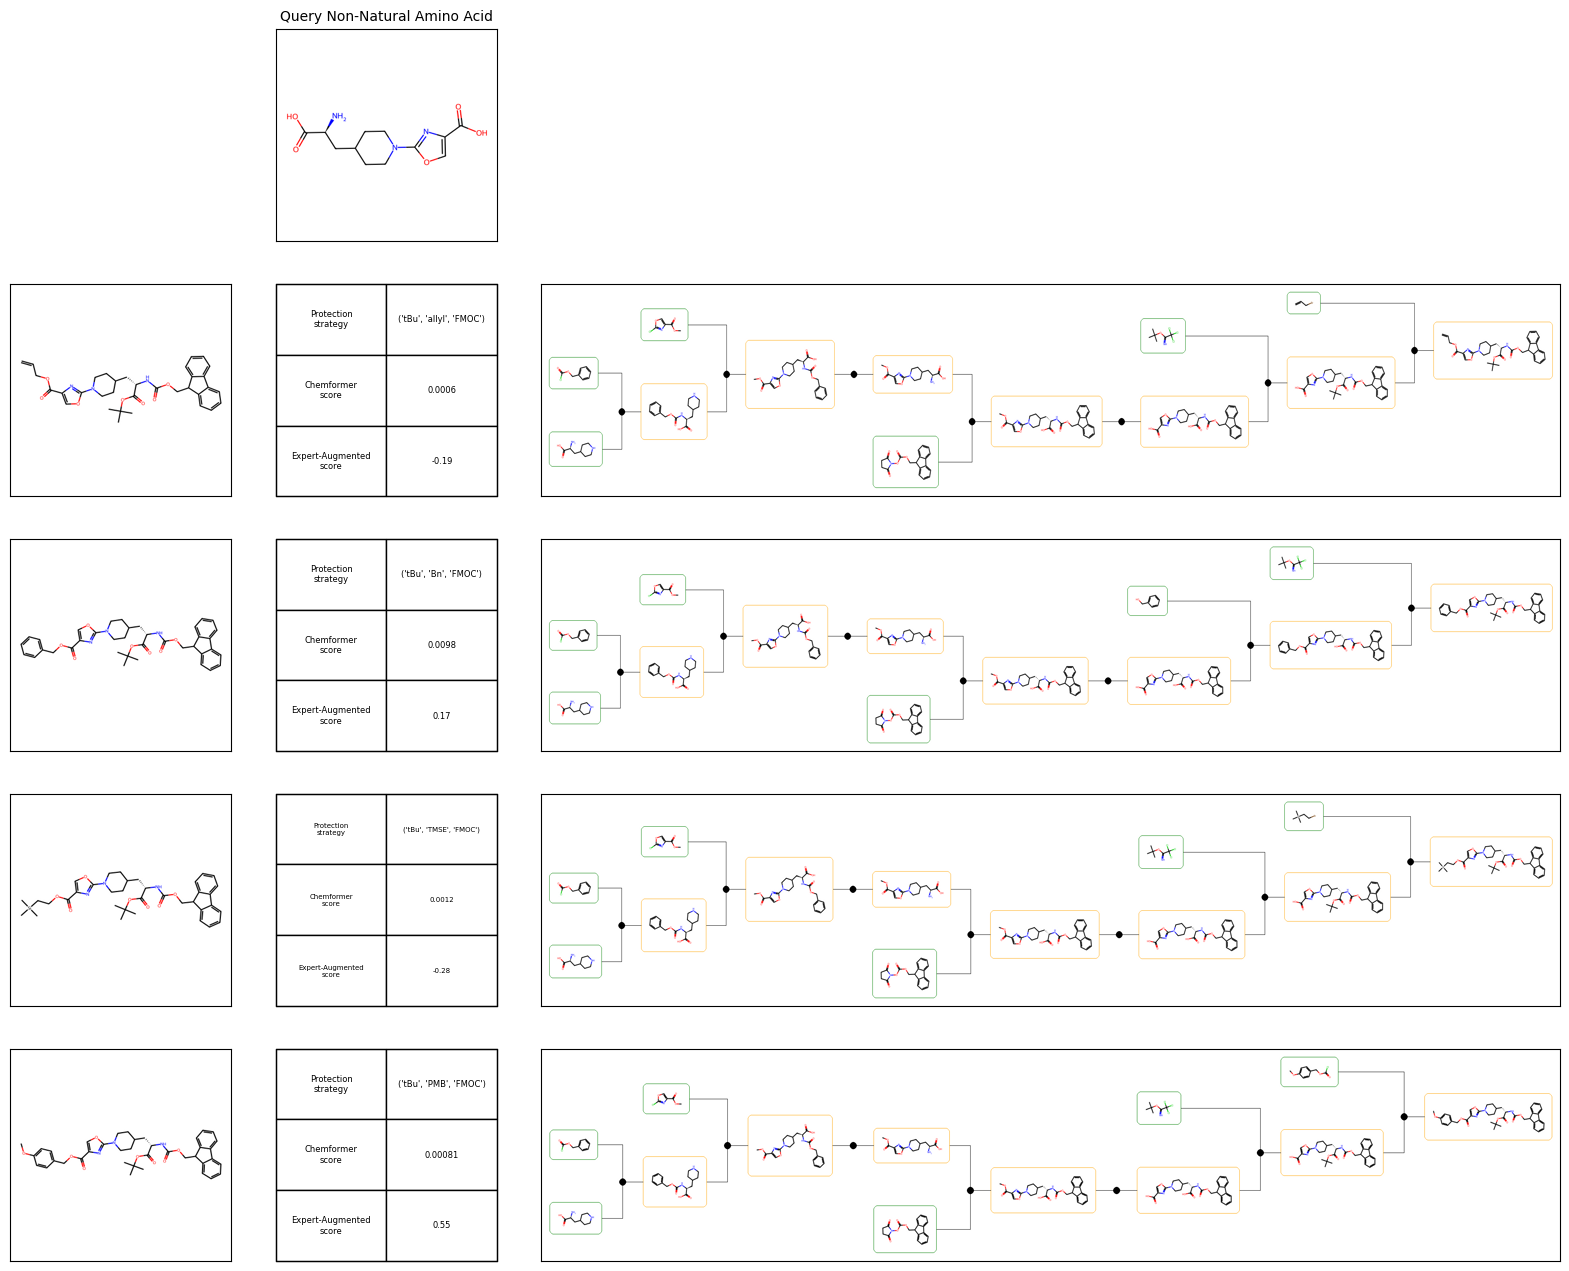

In [10]:
from nnaasynth.utils.plotting import plot_results
save_to = os.path.join(path_to_save, "nnaa_synthesizability_results.png")
query_amino_acid = "N[C@@H](CC1CCN(c2nc(C(=O)O)co2)CC1)C(=O)O"

analyzer = RunSynthesizabilityAnalysis(protection, aizynthfinder, feasibility)
best_routes = analyzer.run_pipeline(query_amino_acid)
plot_results(query_amino_acid, best_routes, save_to)